<a href="https://colab.research.google.com/github/WoradeeKongthong/image_classification/blob/master/cat_or_not_image_binary_classification_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import h5py
import numpy as np

# Load dataset

In [2]:
train_dataset = h5py.File('train_catvnoncat.h5', 'r')
test_dataset = h5py.File('test_catvnoncat.h5', 'r')

In [3]:
type(train_dataset)

h5py._hl.files.File

In [4]:
print(list(train_dataset.keys()))
print(list(test_dataset.keys()))

['list_classes', 'train_set_x', 'train_set_y']
['list_classes', 'test_set_x', 'test_set_y']


In [5]:
trainX = np.array(train_dataset['train_set_x'])
trainy = np.array(train_dataset['train_set_y'])
testX = np.array(test_dataset['test_set_x'])
testy = np.array(test_dataset['test_set_y'])

In [6]:
# summary dataset shape
print('trainX shape : ', trainX.shape)
print('trainy shape : ', trainy.shape)
print('testX shape : ', testX.shape)
print('testy shape : ', testy.shape)

trainX shape :  (209, 64, 64, 3)
trainy shape :  (209,)
testX shape :  (50, 64, 64, 3)
testy shape :  (50,)


In [7]:
trainX[0].dtype

dtype('uint8')

# Plot sample data

In [8]:
from matplotlib import pyplot as plt
from random import randint

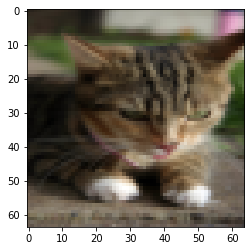

Cat or NonCat :  1


In [12]:
# print example image and label
sample = randint(0,len(trainX)-1)
plt.imshow(trainX[sample])
plt.show()
print('Cat or NonCat : ', trainy[sample])

# Create Data Generator

In [13]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [14]:
# create generator
datagen = ImageDataGenerator(featurewise_center=True)
datagen.mean = [123.68, 116.779, 103.939]

# prepare iterator
train_it = datagen.flow(trainX, trainy, batch_size=10)
test_it = datagen.flow(testX, testy, batch_size=10)

# Baseline Model : Transfer Learning with VGG16
VGG16 as an integrated feature extractor

In [26]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD

In [27]:
VGG16

<function tensorflow.python.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000, classifier_activation='softmax')>

In [29]:
# define model
def baseline_model():
  # load vgg16
  model = VGG16(include_top=False, input_shape=(64,64,3))
  # mark loaded layers as not trainable
  for layer in model.layers :
    layer.trainable = False
  
  # add classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  fc1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  output = Dense(1, activation='sigmoid')(fc1)

  # define model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [30]:
model = baseline_model()

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

# Fit the model

In [32]:
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=10)

/home/samantha/anaconda3/envs/virtual_platform_CV/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
21/21 [==============================] - 7s 287ms/step - loss: 2.8963 - accuracy: 0.7431 - val_loss: 5.6630 - val_accuracy: 0.8600
Epoch 2/10
21/21 [==============================] - 6s 285ms/step - loss: 0.4119 - accuracy: 0.9891 - val_loss: 3.1058 - val_accuracy: 0.9200
Epoch 3/10
21/21 [==============================] - 6s 313ms/step - loss: 0.2331 - accuracy: 0.9588 - val_loss: 5.1061 - val_accuracy: 0.9000
Epoch 4/10
21/21 [==============================] - 7s 356ms/step - loss: 0.0251 - accuracy: 0.9966 - val_loss: 3.2749 - val_accuracy: 0.9400
Epoch 5/10
21/21 [==============================] - 8s 400ms/step - loss: 0.1050 - accuracy: 0.9950 - val_loss: 3.8654 - val_accuracy: 0.9200
Epoch 6/10
21/21 [==============================] - 8s 362ms/step - loss: 1.7588e-04 - accuracy: 1.0000 - val_loss: 4.3895 - val_accuracy: 0.9000
Epoch 7/10
21/21 [==============================] - 7s 358ms/step - loss: 1.4870e-06 - accuracy: 1.0000 - val_loss: 4.4407 - val_accuracy: 0.900

# Results : learning curve and model performance

In [33]:
# plot learning curve and print model performance
def summarize_model(history):
  # learning curve
  plt.figure(figsize=(8,8))

  # plot loss
  plt.subplot(211)
  plt.plot(history.history['loss'], color='green', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='validation')
  plt.title('Cross Entropy Loss')
  plt.legend()

  # plot accuracy
  plt.subplot(212)
  plt.plot(history.history['accuracy'], color='green', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='validation')
  plt.title('Classification Accuracy')
  plt.legend()
  plt.show()
  
  # model performance
  _, train_acc = model.evaluate(train_it, steps=len(train_it), verbose=0)
  _, test_acc = model.evaluate(test_it, steps=len(test_it), verbose=0)
  print('Model Performance (accuracy)')
  print('Train : %.3f' %train_acc)
  print('Test :  %.3f' %test_acc)

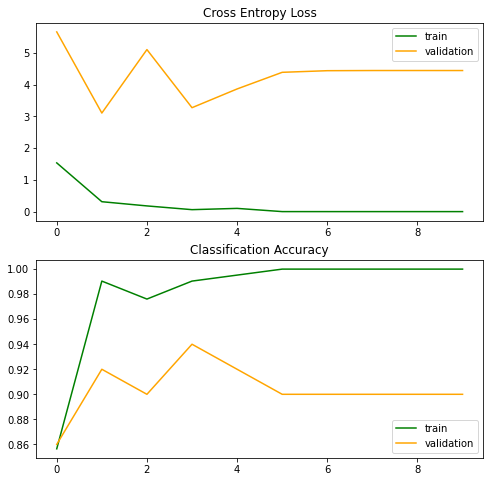

Model Performance (accuracy)
Train : 1.000
Test :  0.900


In [34]:
summarize_model(history)

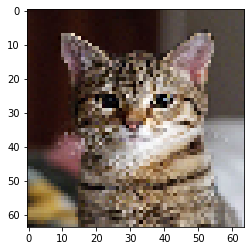

(1, 64, 64, 3)
[[1.]]


/home/samantha/anaconda3/envs/virtual_platform_CV/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [35]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img = load_img('cat.jpg', target_size=(64, 64))
plt.imshow(img)
plt.show()

sample = img_to_array(img)
sample = np.expand_dims(sample, axis=0)
print(sample.shape)

sample_it = datagen.flow(sample, batch_size=1)
ypred = model.predict_generator(sample_it)
print(ypred)

# Develop model01 : add Dropout layer

In [36]:
from tensorflow.keras.layers import Dropout

In [37]:
# define model
def model01():
  # load vgg16
  model = VGG16(include_top=False, input_shape=(64,64,3))
  # mark loaded layers as not trainable
  for layer in model.layers :
    layer.trainable = False
  
  # add classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  fc1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  dropout1 = Dropout(0.2)(fc1)
  output = Dense(1, activation='sigmoid')(dropout1)

  # define model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

Epoch 1/10
21/21 [==============================] - 6s 276ms/step - loss: 3.1000 - accuracy: 0.8235 - val_loss: 3.6717 - val_accuracy: 0.8800
Epoch 2/10
21/21 [==============================] - 6s 302ms/step - loss: 1.8235 - accuracy: 0.9493 - val_loss: 2.7119 - val_accuracy: 0.9000
Epoch 3/10
21/21 [==============================] - 6s 300ms/step - loss: 0.0864 - accuracy: 0.9815 - val_loss: 2.9105 - val_accuracy: 0.9200
Epoch 4/10
21/21 [==============================] - 7s 320ms/step - loss: 0.0436 - accuracy: 0.9898 - val_loss: 3.7403 - val_accuracy: 0.9200
Epoch 5/10
21/21 [==============================] - 7s 359ms/step - loss: 0.0737 - accuracy: 0.9898 - val_loss: 4.4118 - val_accuracy: 0.8800
Epoch 6/10
21/21 [==============================] - 7s 345ms/step - loss: 4.0403e-06 - accuracy: 1.0000 - val_loss: 4.3451 - val_accuracy: 0.8800
Epoch 7/10
21/21 [==============================] - 8s 376ms/step - loss: 7.0828e-05 - accuracy: 1.0000 - val_loss: 4.3367 - val_accuracy: 0.880

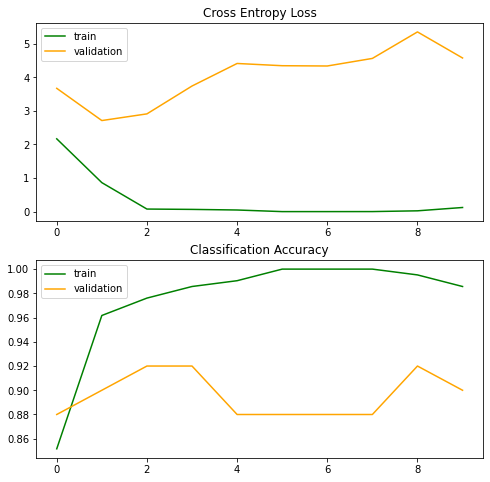

Model Performance (accuracy)
Train : 1.000
Test :  0.900


In [38]:
model = model01()
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=10)
summarize_model(history)

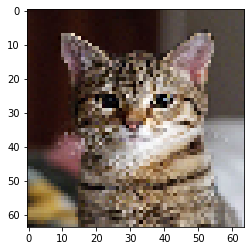

(1, 64, 64, 3)
[[1.]]


In [39]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img = load_img('cat.jpg', target_size=(64, 64))
plt.imshow(img)
plt.show()

sample = img_to_array(img)
sample = np.expand_dims(sample, axis=0)
print(sample.shape)

sample_it = datagen.flow(sample, batch_size=1)
ypred = model.predict_generator(sample_it)
print(ypred)

# Develop model02 : additional fully connected layer and dropout

In [40]:
# define model
def model02():
  # load vgg16
  model = VGG16(include_top=False, input_shape=(64,64,3))
  # mark loaded layers as not trainable
  for layer in model.layers :
    layer.trainable = False
  
  # add classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  fc1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  dropout1 = Dropout(0.2)(fc1)
  fc2 = Dense(64, activation='relu', kernel_initializer='he_uniform')(dropout1)
  dropout2 = Dropout(0.2)(fc2)
  output = Dense(1, activation='sigmoid')(dropout2)

  # define model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

Epoch 1/10
21/21 [==============================] - 7s 294ms/step - loss: 4.4809 - accuracy: 0.7032 - val_loss: 2.6884 - val_accuracy: 0.9000
Epoch 2/10
21/21 [==============================] - 6s 287ms/step - loss: 0.7053 - accuracy: 0.9436 - val_loss: 1.6531 - val_accuracy: 0.9400
Epoch 3/10
21/21 [==============================] - 6s 311ms/step - loss: 0.3083 - accuracy: 0.9766 - val_loss: 2.8106 - val_accuracy: 0.9000
Epoch 4/10
21/21 [==============================] - 7s 321ms/step - loss: 0.7883 - accuracy: 0.9454 - val_loss: 3.5909 - val_accuracy: 0.9200
Epoch 5/10
21/21 [==============================] - 7s 331ms/step - loss: 0.0699 - accuracy: 0.9901 - val_loss: 4.1408 - val_accuracy: 0.9200
Epoch 6/10
21/21 [==============================] - 8s 376ms/step - loss: 0.3039 - accuracy: 0.9823 - val_loss: 4.0549 - val_accuracy: 0.9200
Epoch 7/10
21/21 [==============================] - 7s 340ms/step - loss: 0.0166 - accuracy: 0.9915 - val_loss: 3.2154 - val_accuracy: 0.9400
Epoch 

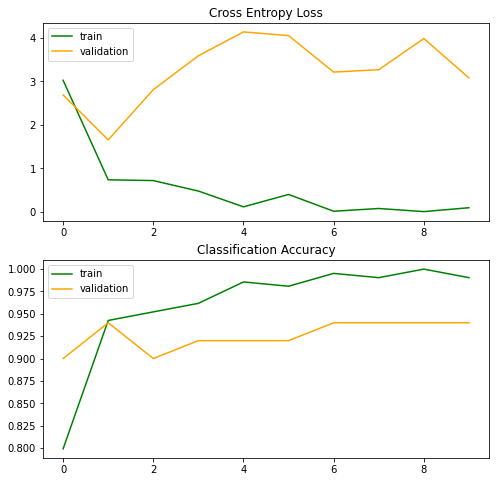

Model Performance (accuracy)
Train : 1.000
Test :  0.940


In [41]:
model = model02()
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=10)
summarize_model(history)

Note : additional fully connected layer doesn't help on increasing performance

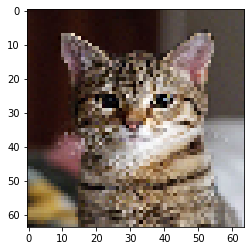

(1, 64, 64, 3)
[[1.]]


In [42]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img = load_img('cat.jpg', target_size=(64, 64))
plt.imshow(img)
plt.show()

sample = img_to_array(img)
sample = np.expand_dims(sample, axis=0)
print(sample.shape)

sample_it = datagen.flow(sample, batch_size=1)
ypred = model.predict_generator(sample_it)
print(ypred)

# Improve model03 : change flatten to be global average pooling

In [43]:
# define model
def model03():
  # load vgg16
  model = VGG16(include_top=False, input_shape=(64,64,3), pooling='avg')
  # mark loaded layers as not trainable
  for layer in model.layers :
    layer.trainable = False
  
  # add classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  fc1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  dropout1 = Dropout(0.2)(fc1)
  output = Dense(1, activation='sigmoid')(dropout1)

  # define model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

Epoch 1/10
21/21 [==============================] - 8s 381ms/step - loss: 2.9420 - accuracy: 0.7572 - val_loss: 2.4664 - val_accuracy: 0.8400
Epoch 2/10
21/21 [==============================] - 8s 386ms/step - loss: 0.2016 - accuracy: 0.9765 - val_loss: 1.9663 - val_accuracy: 0.8800
Epoch 3/10
21/21 [==============================] - 8s 363ms/step - loss: 0.1983 - accuracy: 0.9743 - val_loss: 1.3300 - val_accuracy: 0.9200
Epoch 4/10
21/21 [==============================] - 7s 354ms/step - loss: 0.1564 - accuracy: 0.9760 - val_loss: 1.3969 - val_accuracy: 0.9000
Epoch 5/10
21/21 [==============================] - 7s 347ms/step - loss: 0.0614 - accuracy: 0.9848 - val_loss: 1.6640 - val_accuracy: 0.8800
Epoch 6/10
21/21 [==============================] - 8s 361ms/step - loss: 0.0086 - accuracy: 0.9955 - val_loss: 1.4603 - val_accuracy: 0.8800
Epoch 7/10
21/21 [==============================] - 7s 356ms/step - loss: 0.0370 - accuracy: 0.9912 - val_loss: 1.7912 - val_accuracy: 0.8600
Epoch 

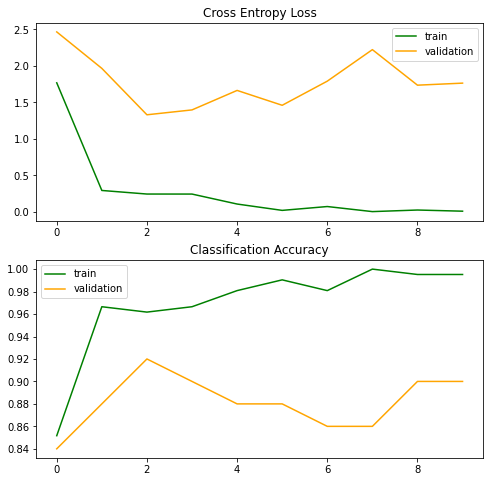

Model Performance (accuracy)
Train : 1.000
Test :  0.900


In [44]:
model = model03()
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=10)
summarize_model(history)

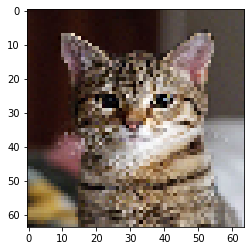

(1, 64, 64, 3)
[[1.]]


In [45]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img = load_img('cat.jpg', target_size=(64, 64))
plt.imshow(img)
plt.show()

sample = img_to_array(img)
sample = np.expand_dims(sample, axis=0)
print(sample.shape)

sample_it = datagen.flow(sample, batch_size=1)
ypred = model.predict_generator(sample_it)
print(ypred)

# Develop model04 : set last VGG-block as trainable

In [46]:
model=VGG16(include_top=False, input_shape=(64,64,3), pooling='avg')
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [47]:
# define model
def model04():
  # load vgg16
  model = VGG16(include_top=False, input_shape=(64,64,3), pooling='avg')
  # mark loaded layers as not trainable
  for layer in model.layers[:-5] :
    layer.trainable = False
  
  # add classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  fc1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  dropout1 = Dropout(0.2)(fc1)
  output = Dense(1, activation='sigmoid')(dropout1)

  # define model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

Epoch 1/20
21/21 [==============================] - 11s 494ms/step - loss: 9.6138 - accuracy: 0.6324 - val_loss: 6.9567 - val_accuracy: 0.6600
Epoch 2/20
21/21 [==============================] - 10s 483ms/step - loss: 5158764.0558 - accuracy: 0.6103 - val_loss: 1611021294764032.0000 - val_accuracy: 0.6600
Epoch 3/20
21/21 [==============================] - 11s 548ms/step - loss: nan - accuracy: 0.6538 - val_loss: nan - val_accuracy: 0.3400
Epoch 4/20
21/21 [==============================] - 10s 488ms/step - loss: nan - accuracy: 0.6656 - val_loss: nan - val_accuracy: 0.3400
Epoch 5/20
21/21 [==============================] - 10s 498ms/step - loss: nan - accuracy: 0.6647 - val_loss: nan - val_accuracy: 0.3400
Epoch 6/20
21/21 [==============================] - 10s 484ms/step - loss: nan - accuracy: 0.6012 - val_loss: nan - val_accuracy: 0.3400
Epoch 7/20
21/21 [==============================] - 10s 487ms/step - loss: nan - accuracy: 0.6233 - val_loss: nan - val_accuracy: 0.3400
Epoch 8/

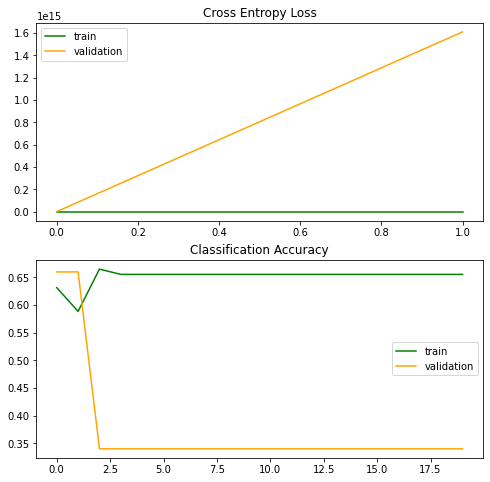

Model Performance (accuracy)
Train : 0.656
Test :  0.340


In [48]:
model = model04()
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20)
summarize_model(history)

# Develop model05 : Data Augmentation

In [49]:
# define model
def model05():
  # create train data generator
  train_datagen = ImageDataGenerator(featurewise_center=True, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, rotation_range=90)
  train_datagen.mean = [123.68, 116.779, 103.939]

  # create test data generator (no data augmentation)
  test_datagen = ImageDataGenerator(featurewise_center=True)
  test_datagen.mean = [123.68, 116.779, 103.939]

  # prepare iterator
  train_it = train_datagen.flow(trainX, trainy, batch_size=10)
  test_it = test_datagen.flow(testX, testy, batch_size=10)
  
  # load vgg16
  model = VGG16(include_top=False, input_shape=(64,64,3), pooling='avg')
  # mark loaded layers as not trainable
  for layer in model.layers :
    layer.trainable = False

  # add classifier layers
  flat1 = Flatten()(model.layers[-1].output)
  fc1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
  dropout1 = Dropout(0.2)(fc1)
  output = Dense(1, activation='sigmoid')(dropout1)

  # define model
  model = Model(inputs=model.inputs, outputs=output)
  # compile model
  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model

Epoch 1/20
21/21 [==============================] - 8s 374ms/step - loss: 3.5712 - accuracy: 0.7340 - val_loss: 2.2866 - val_accuracy: 0.8400
Epoch 2/20
21/21 [==============================] - 8s 367ms/step - loss: 0.4233 - accuracy: 0.9371 - val_loss: 1.1571 - val_accuracy: 0.9000
Epoch 3/20
21/21 [==============================] - 7s 348ms/step - loss: 0.2159 - accuracy: 0.9778 - val_loss: 1.1912 - val_accuracy: 0.9000
Epoch 4/20
21/21 [==============================] - 7s 351ms/step - loss: 0.1565 - accuracy: 0.9694 - val_loss: 1.2518 - val_accuracy: 0.9400
Epoch 5/20
21/21 [==============================] - 7s 355ms/step - loss: 0.0192 - accuracy: 0.9969 - val_loss: 1.1039 - val_accuracy: 0.9200
Epoch 6/20
21/21 [==============================] - 7s 356ms/step - loss: 0.0153 - accuracy: 0.9877 - val_loss: 1.1248 - val_accuracy: 0.9200
Epoch 7/20
21/21 [==============================] - 7s 346ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.1258 - val_accuracy: 0.9200
Epoch 

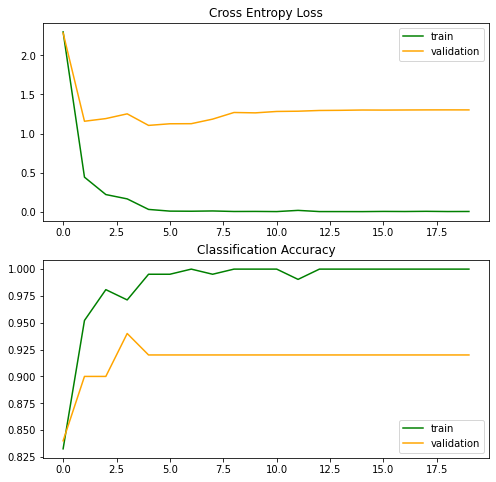

Model Performance (accuracy)
Train : 1.000
Test :  0.920


In [50]:
model = model05()
history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=20)
summarize_model(history)

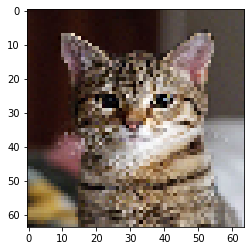

(1, 64, 64, 3)
[[1.]]


In [51]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img = load_img('cat.jpg', target_size=(64, 64))
plt.imshow(img)
plt.show()

sample = img_to_array(img)
sample = np.expand_dims(sample, axis=0)
print(sample.shape)

sample_it = datagen.flow(sample, batch_size=1)
ypred = model.predict_generator(sample_it)
print(ypred)

# Finalize and Save the model
Selected model : baseline model  
Finalize the model : fit the model with entire training set  
Save the model as .h5 

In [52]:
model = baseline_model()
model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=20)
# Save the Model
model.save('final_model.h5')

Epoch 1/20
21/21 [==============================] - 5s 229ms/step - loss: 2.6299 - accuracy: 0.7800
Epoch 2/20
21/21 [==============================] - 5s 244ms/step - loss: 0.5030 - accuracy: 0.9746
Epoch 3/20
21/21 [==============================] - 6s 266ms/step - loss: 0.0600 - accuracy: 0.9911
Epoch 4/20
21/21 [==============================] - 6s 278ms/step - loss: 0.2901 - accuracy: 0.9838
Epoch 5/20
21/21 [==============================] - 6s 271ms/step - loss: 0.0090 - accuracy: 0.9960
Epoch 6/20
21/21 [==============================] - 6s 283ms/step - loss: 7.0352e-05 - accuracy: 1.0000
Epoch 7/20
21/21 [==============================] - 7s 310ms/step - loss: 4.2097e-07 - accuracy: 1.0000
Epoch 8/20
21/21 [==============================] - 7s 321ms/step - loss: 3.2937e-06 - accuracy: 1.0000
Epoch 9/20
21/21 [==============================] - 6s 285ms/step - loss: 4.1101e-06 - accuracy: 1.0000
Epoch 10/20
21/21 [==============================] - 6s 275ms/step - loss: 2.2111e-0

# Prediction
Make a prediction on a single image with the saved final model

In [53]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

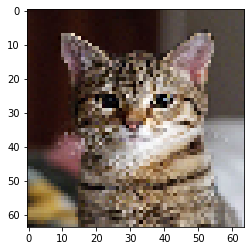

(64, 64, 3)


In [54]:
# load image
img = load_img('cat.jpg', target_size=(64, 64))
# plot image
plt.imshow(img)
plt.show()

# convert image to array
img = img_to_array(img)
print(img.shape)

In [55]:
# reshape image to single sample with 1 channel
sample = img.reshape(1,64,64,3)

# create generator without data augmentation
datagen = ImageDataGenerator(featurewise_center=True)
datagen.mean = [123.68, 116.779, 103.939]

# prepare iterator
sample_it = datagen.flow(sample, batch_size=1)

# load model
model = load_model('final_model.h5')

# make prediction
result = model.predict(sample_it)
print('prediction : ', result[0])

prediction :  [1.]
